In [67]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


[*********************100%***********************]  1 of 1 completed


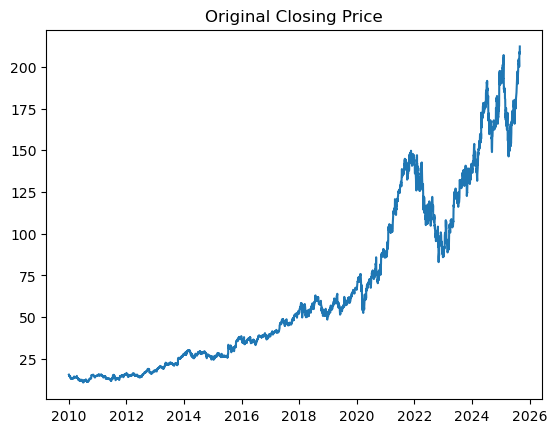

In [68]:
ticker = "GOOG"
df = yf.download(ticker, start="2010-01-01", end="2025-08-29")[["Close"]]
df.rename(columns={"Close":"close"}, inplace=True)
df.dropna(inplace=True)

plt.plot(df['close'])
plt.title("Original Closing Price")
plt.show()


In [69]:
result = adfuller(df["close"])
pvalue = result[1]
print("ADF p-value:", pvalue)
original_prices = df["close"].values  # original stock prices

ADF p-value: 0.9951337027808951


In [70]:
random_noise = df['close'].diff().dropna()

mean_noise = random_noise.mean()
mean_noise

Ticker
GOOG    0.049956
dtype: float64

In [71]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['close']])

In [72]:
def create_dataset(data, time_step=50):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step, 0])
        y.append(data[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 50
X, y = create_dataset(scaled, time_step)

In [73]:
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
X_test  = X[train_size:]
y_train = y[:train_size]
y_test  = y[train_size:]

test_start_idx = train_size + time_step

In [74]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_pred_scaled = lr.predict(X_test)

In [75]:
lr_pred = scaler.inverse_transform(lr_pred_scaled.reshape(-1,1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

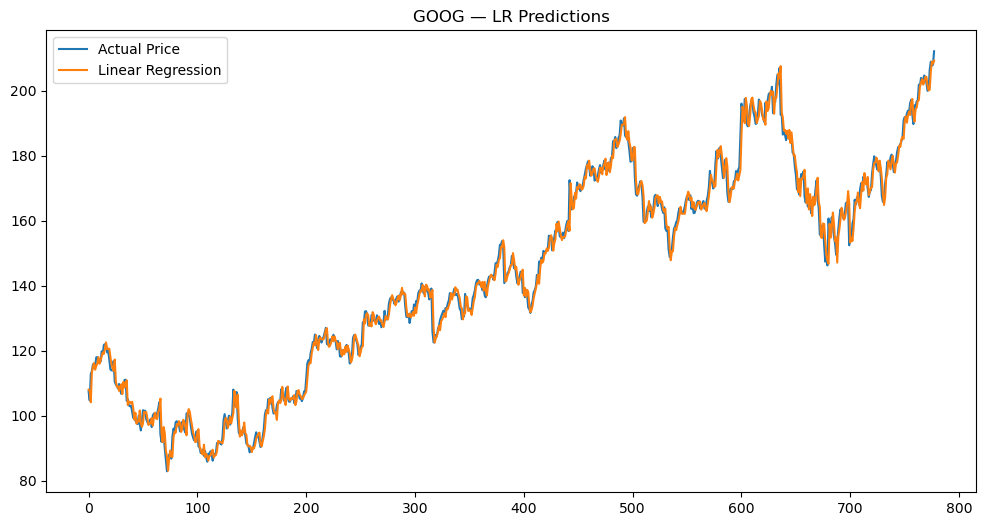

In [76]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Actual Price")
plt.plot(lr_pred, label="Linear Regression")
plt.legend()
plt.title("GOOG — LR Predictions")
plt.show()

In [77]:
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)

ridge_pred_scaled = ridge.predict(X_test)
ridge_pred = scaler.inverse_transform(ridge_pred_scaled.reshape(-1,1))

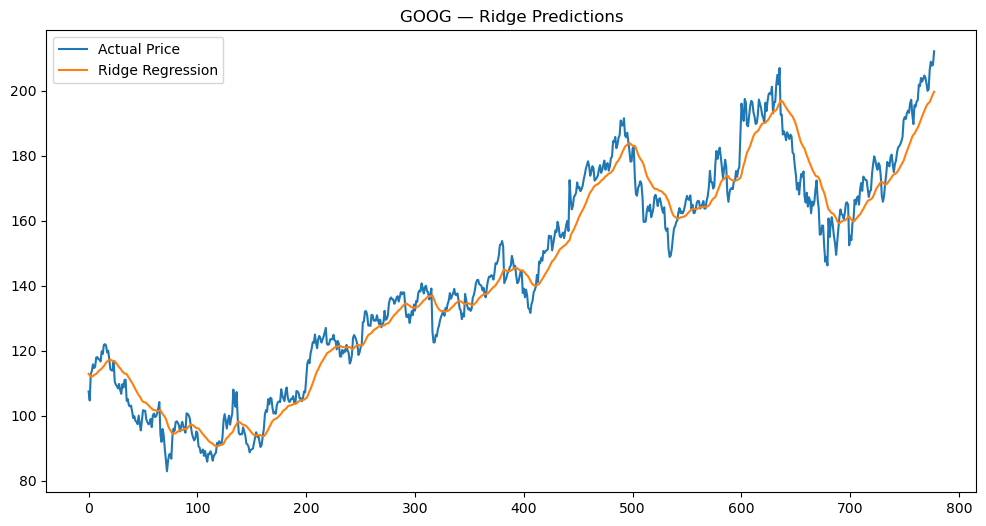

In [78]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Actual Price")
plt.plot(ridge_pred, label="Ridge Regression")
plt.legend()
plt.title("GOOG — Ridge Predictions")
plt.show()

In [79]:
X_train_lstm = X_train.reshape(X_train.shape[0], time_step, 1)
X_test_lstm  = X_test.reshape(X_test.shape[0], time_step, 1)

In [80]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(time_step,1)),
    Dropout(0.2),
    Dense(1)
])

model.compile(loss="mse", optimizer="adam")

model.fit(X_train_lstm, y_train, epochs=20, batch_size=32,
          validation_data=(X_test_lstm, y_test),
          verbose=1)

Epoch 1/20


c:\Users\dpiso\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0047 - val_loss: 7.5512e-04
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.9218e-04 - val_loss: 7.1310e-04
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.5080e-04 - val_loss: 8.3817e-04
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.6868e-04 - val_loss: 0.0030
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.0250e-04 - val_loss: 0.0012
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.9316e-04 - val_loss: 6.7319e-04
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.6500e-04 - val_loss: 0.0013
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.4168e-04 - val_loss: 6.9758e-04
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.7793e-04 - val_loss: 0.0015
Epoch 10/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3802e-04 - val_loss: 5.5640e-04
Epoch 11/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0367e-04 - val_loss: 6.2591e-04
Epoch 

In [81]:
lstm_pred = model.predict(X_test_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, lstm_pred))

print("LSTM RMSE:", rmse_lstm)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
LSTM RMSE: 0.023118374897340564


In [82]:
lstm_pred_scaled = model.predict(X_test_lstm)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


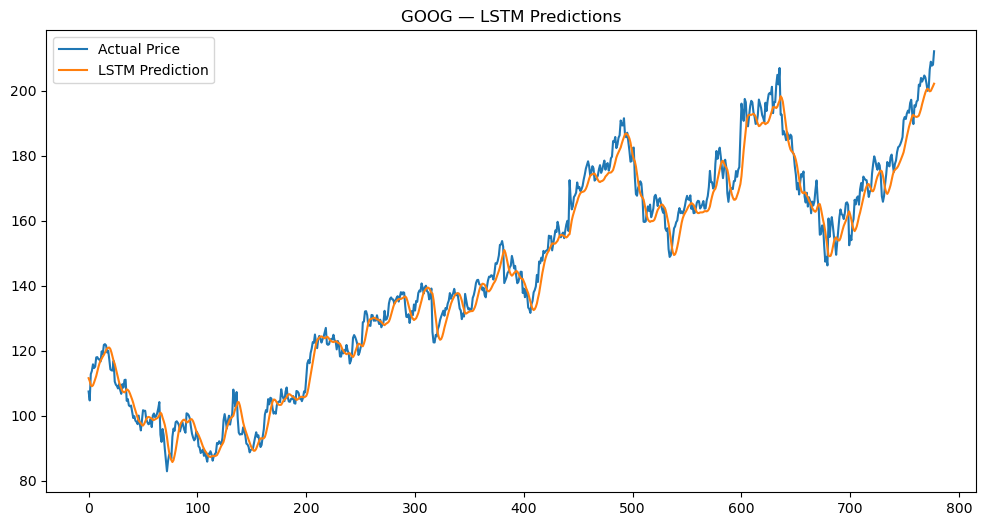

In [83]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Actual Price")
plt.plot(lstm_pred, label="LSTM Prediction")
plt.legend()
plt.title("GOOG — LSTM Predictions")
plt.show()

In [84]:
std_dev = np.std(scaled)

random_data = np.random.normal(loc=mean_noise, scale=std_dev, size=y_test_inv.shape)

In [85]:
random_walk = y_test_inv + random_data

In [86]:
lstm_pred.shape, random_walk.shape

((778, 1), (778, 1))

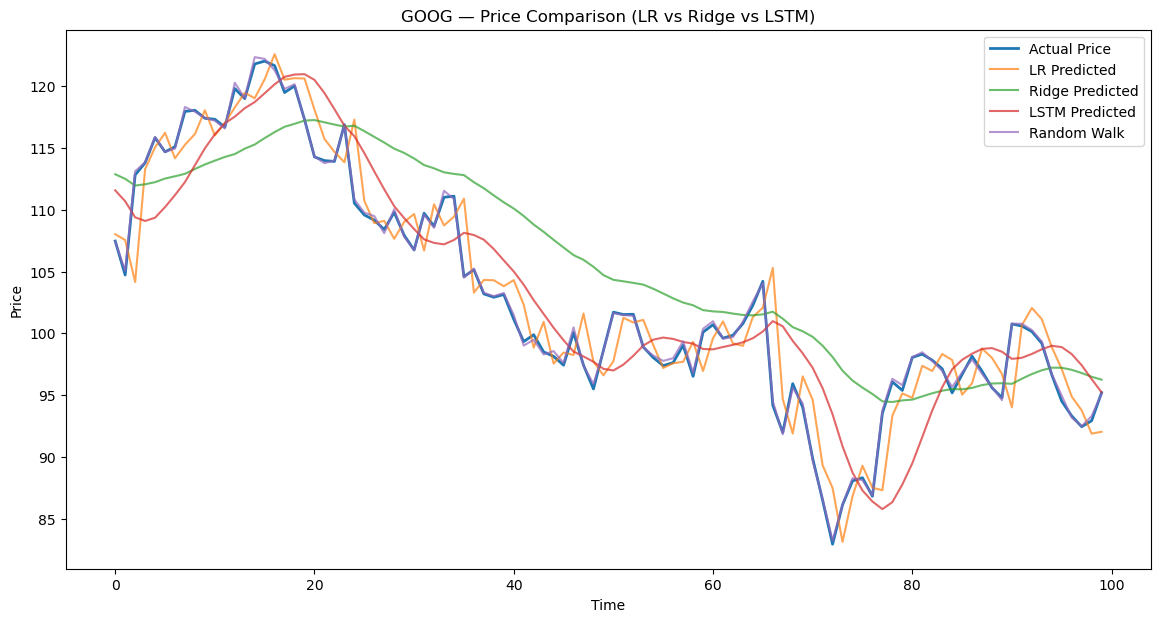

In [87]:
plt.figure(figsize=(14,7))
plt.plot(y_test_inv[:100], label="Actual Price", linewidth=2)
plt.plot(lr_pred[:100], label="LR Predicted", alpha=0.7)
plt.plot(ridge_pred[:100], label="Ridge Predicted", alpha=0.7)
plt.plot(lstm_pred[:100], label="LSTM Predicted", alpha=0.7)
plt.plot(random_walk[:100], label="Random Walk", alpha=0.7)

plt.title(f"{ticker} — Price Comparison (LR vs Ridge vs LSTM)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()